# Investigating `mlx_whisper` audio preprocessing

We aim to adversarially optimize audio through `whisper`, to see if we can attack the transcription model, and what the effect is on the audio. 

I am not so interested in adversarial robustness or maximally effective attacks, and care more about the realism of the resulting audio. If it is realistic, we could for example use the resulting data to augment training data.

To run this notebook, you'll need:
- a decent Macbook with >= 24GB memory
- `uv`

### Optimizing through Whisper 

Whisper is an encoder-decoder transformer which passes a log mel spectrogram input to the encoder. Optimizing the log mel spectrogram would likely work already, but does not allow us to create crisp sounding audio. 

The reason is that the transformation from waveform to log Mel spectrogram is lossy in two places:

- We discard the phase information, only using the (square of the) magnitudes
- We apply a Mel filterbank to transform magnitudes to mel-scale, a non-invertible operation

We can solve the first issue by just remembering the original (complex) spectrogram. In the absence of original audio, phase information is sometimes reconstructed using Griffin-Lim, but in my experience these reconstructions are quite poor. We also have access to the original audio here, no need to guess the phase.

Since we're optimizing the audio signal using backpropagation, we can solve the second issue by simply computing gradients w.r.t. the magnitudes (applying the Mel filters is a matrix multiplication).

Let's first investigate what the intermediate outputs for Whisper preprocessing look like, and whether we can reconstruct audio to begin with. 

In [1]:
%matplotlib inline

from pathlib import Path
from mlx_audio_opt import REPO_ROOT

## Define your settings here

class Settings:
    # the .wav file to use
    wav_file = REPO_ROOT / 'data' / '33711__acclivity__excessiveexposure.wav'

    # the model id
    model_id = "mlx-community/whisper-small-mlx"

    # dtype for inference
    dtype = "fp16"

assert Settings.wav_file.exists(), f"File {Settings.wav_file} does not exist"


/Users/auke/code/deepgram/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using wav file: '/Users/auke/code/deepgram/data/33711__acclivity__excessiveexposure.wav'


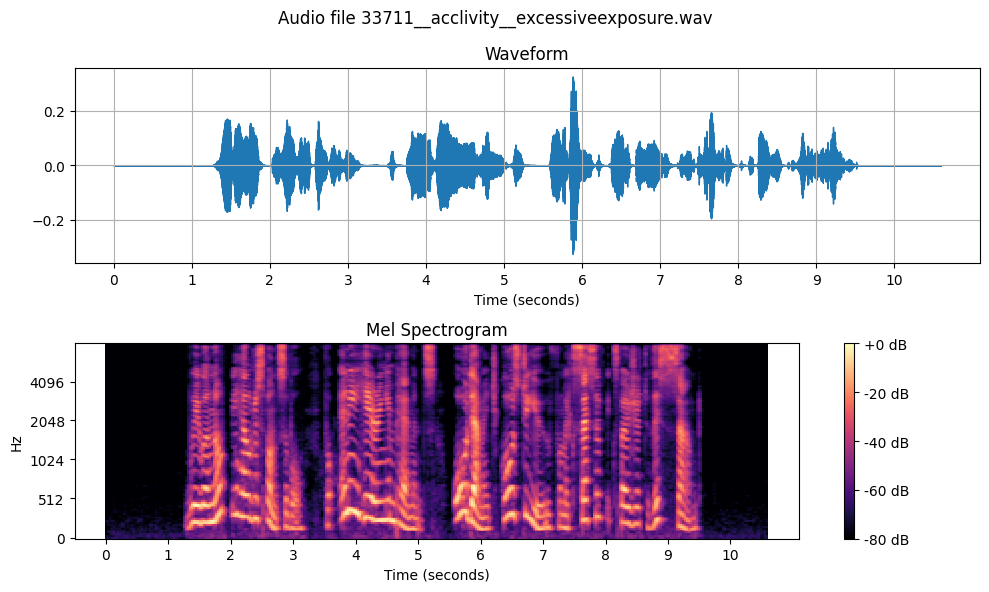

In [2]:
from mlx_whisper.audio import SAMPLE_RATE
import matplotlib.pyplot as plt

from mlx_audio_opt.visualization.plot_audio import visualize_audio

print(f"Using wav file: '{Settings.wav_file}'")
fig = visualize_audio(Settings.wav_file, sampling_rate=SAMPLE_RATE)
plt.show()

Using Librosa, we can visualize the waveform and its Mel spectrogram. For audio containing speech this should clearly highlight vowels, pauses, music, etc. Some people can read spoken words from mel spectrograms by recognizing the vowel patterns, so do try listening to the audio and see if you can make out some text or sounds. 

Whisper uses a normalized log mel spectrogram input for the audio encoder, and uses a custom number of mel filters for each model. The outcome will look slightly different than Librosa's default choices, let's compare them below.

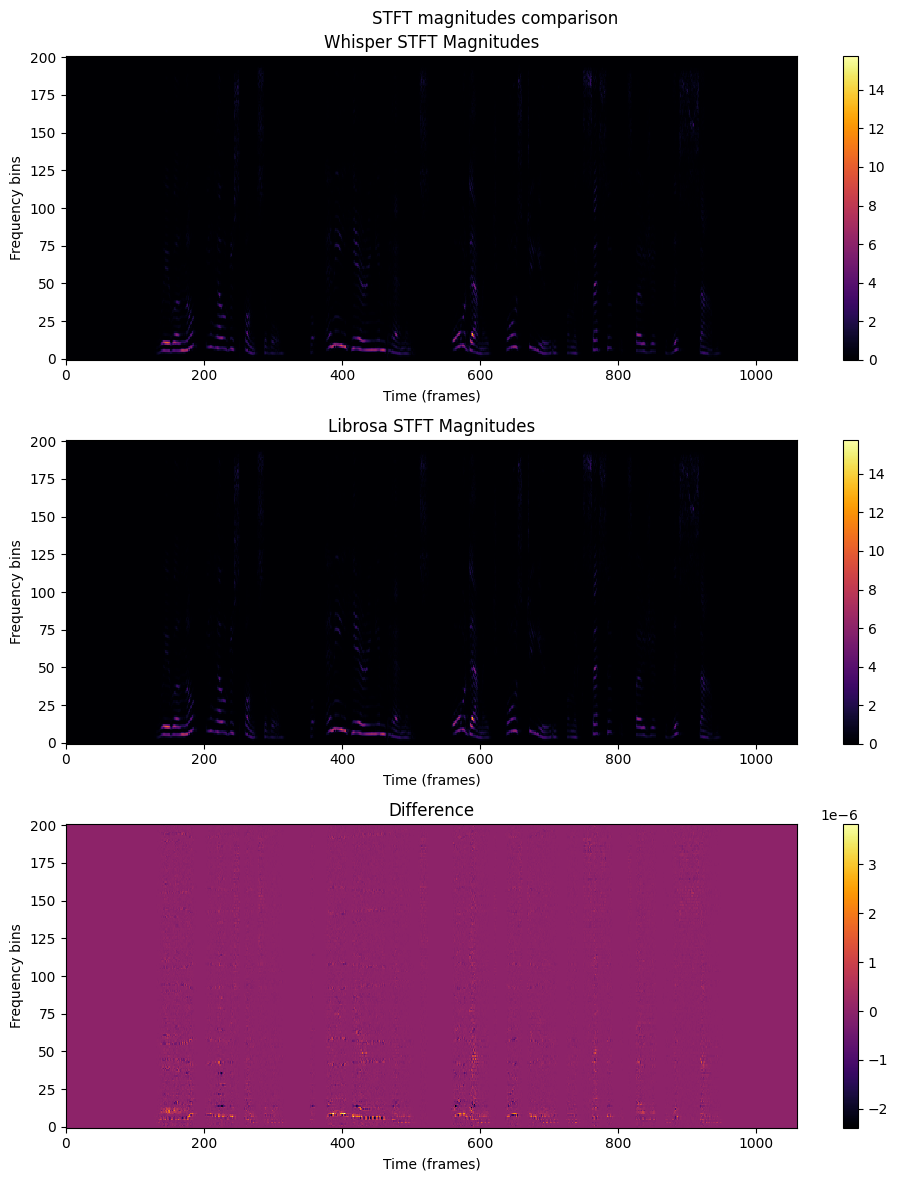

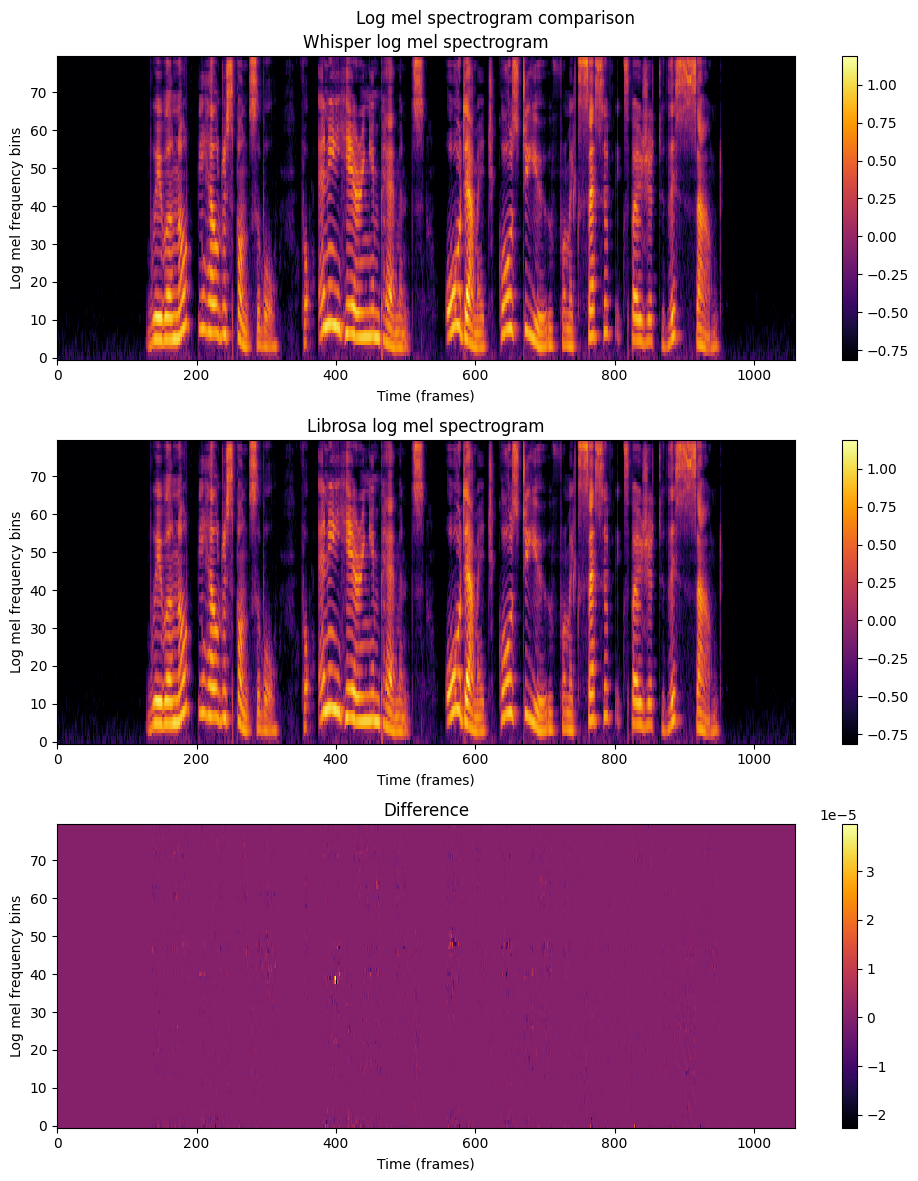

In [3]:
import mlx.core as mx
from mlx_whisper.audio import HOP_LENGTH, N_FFT, SAMPLE_RATE, hanning, stft, load_audio
import numpy as np
import matplotlib.pyplot as plt
import librosa

from mlx_audio_opt.audio.stft import magnitudes_to_log_mel_spectrogram
from mlx_audio_opt.visualization.plot_audio import compare_spectrograms


def get_whisper_spec(audio_series: mx.array):
    window = hanning(N_FFT)
    complex_spectrogram = stft(
        audio_series,
        nperseg=N_FFT,  # similar to librosa's n_fft, window_length
        window=window,  # in librosa we can specify 'hann' to get the same hanning window
        noverlap=HOP_LENGTH,  # similar to librosa's hop_length
    )
    magnitudes = complex_spectrogram.abs()
    log_mel_spectrogram = magnitudes_to_log_mel_spectrogram(magnitudes)
    return magnitudes.T, log_mel_spectrogram.T


def get_librosa_spec(audio_series: mx.array):
    complex_spectrogram = librosa.stft(
        np.array(audio_series),
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=N_FFT,
        window="hann",
        pad_mode="reflect",
    )
    # librosa stft outputs (n_fft//2+1, n_frames)
    magnitudes = mx.array(np.abs(complex_spectrogram).T)
    log_mel_spectrogram = magnitudes_to_log_mel_spectrogram(magnitudes)
    return magnitudes.T, log_mel_spectrogram.T


def compare_whisper_and_librosa(wav_file: Path):
    audio_array, _ = librosa.load(wav_file, sr=SAMPLE_RATE)
    audio_array = mx.array(audio_array)
    magnitudes_wh, log_mel_spectrogram_wh = get_whisper_spec(audio_array)
    magnitudes_lr, log_mel_spectrogram_lr = get_librosa_spec(audio_array)

    compare_spectrograms(
        magnitudes1=magnitudes_wh,
        magnitudes2=magnitudes_lr,
        title1="Whisper STFT Magnitudes",
        title2="Librosa STFT Magnitudes",
        suptitle="STFT magnitudes comparison",
        ylabel="Frequency bins",
    )
    plt.show()
    compare_spectrograms(
        magnitudes1=log_mel_spectrogram_wh,
        magnitudes2=log_mel_spectrogram_lr,
        title1="Whisper log mel spectrogram",
        title2="Librosa log mel spectrogram",
        suptitle="Log mel spectrogram comparison",
        ylabel="Log mel frequency bins",
    )
    plt.show()


compare_whisper_and_librosa(Settings.wav_file)

The log mel spectrograms look similar at first glance, but the difference plot shows quite a few (small) differences. Different implementation choices by the two libraries affect the end result, for example, the `mx.fft` implementations may not match Librosa's exactly. 

Judging visually or numerically how close spectrograms are is tough. Ideally, we want to implement an inverse `stft` (aka `istft`) for `mlx_whisper`, but a perfect match with librosa be challenging due to handling of edge cases.. take a look at how Librosa's `istft` implementation handles the different padding options to see why.

Let's first try reconstructing the audio using Librosa's `istft` implementation for both ways of computing the spectrogram. We should be able to hear the impact of using the "wrong" spectrogram.

In [4]:
from IPython.display import Audio, display
import librosa
import mlx.core as mx

from mlx_audio_opt.audio.istft import reconstruct_audio_from_spectrogram
from mlx_audio_opt.audio.spectrogram import Spectrogram
from mlx_audio_opt.visualization.display_audio_player import display_audio_player


def reconstruct_audio(wav_file: Path):
    audio_series, sampling_rate = librosa.load(wav_file, sr=SAMPLE_RATE)

    display_audio_player(audio_series, "Original audio")
    reconstruct_audio_whisper(audio_series)
    reconstruct_audio_librosa(audio_series)


def reconstruct_audio_whisper(audio_series: np.ndarray):
    audio = mx.array(audio_series)
    window = hanning(N_FFT)
    complex_spectrogram = stft(
        audio,
        nperseg=N_FFT,
        window=window,
        noverlap=HOP_LENGTH,
        pad_mode="reflect",
    )
    # transpose and convert to numpy, angle is not supported in mlx
    magnitudes = np.abs(complex_spectrogram.T)
    phase = np.angle(complex_spectrogram.T)
    spectrogram = Spectrogram(magnitudes, phase)

    # Reconstruct the audio using the inverse STFT
    audio_reconstructed = reconstruct_audio_from_spectrogram(spectrogram)
    display_audio_player(
        audio_reconstructed,
        title="mlx_whisper stft, librosa istft",
    )


def reconstruct_audio_librosa(audio_series: np.ndarray):
    complex_spectrogram = librosa.stft(
        audio_series,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=N_FFT,
        window=np.array(hanning(N_FFT)),
        center=False,
        pad_mode="reflect",
    )
    magnitudes = np.abs(complex_spectrogram)
    phase = np.angle(complex_spectrogram)
    spectrogram = Spectrogram(magnitudes, phase)

    # Reconstruct the audio using the inverse STFT
    audio_reconstructed = reconstruct_audio_from_spectrogram(spectrogram)
    display_audio_player(
        audio_reconstructed,
        title="librosa stft, librosa istft",
    )


reconstruct_audio(Settings.wav_file)

'Original audio'

'mlx_whisper stft, librosa istft'

'librosa stft, librosa istft'

These all sound nearly the same. Let's assume we can reconstruct audio using Librosa's `istft` implementation for now.

The next question is whether we can fool the Whisper model by modifying its input. Let's first see what a `whisper-small` model makes of the audio sample, and visualize the transcription probabilities.

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 102300.10it/s]


Transcription: ' We will not be held responsible for any hearing impairments or damage caused to you from excessive exposure to this sound.'


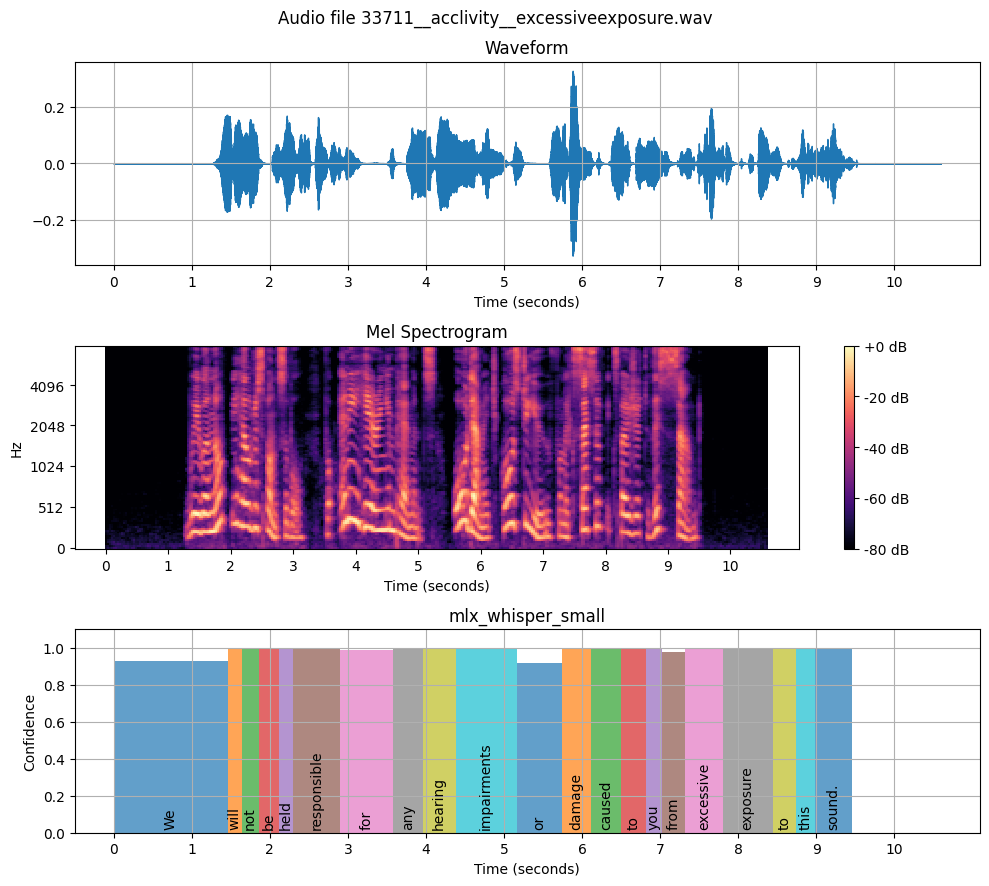

In [5]:
from mlx_audio_opt.stt import whisper
from mlx_audio_opt.stt.transcription import WhisperTranscription
import matplotlib.pyplot as plt


def transcribe(
    wav_file: Path,
    model_id: str,
    dtype: str,
):
    transcription: WhisperTranscription = whisper.transcribe_audio(
        audio=wav_file,
        model_id=model_id,
        fp16=dtype == "fp16",
    )
    print(f"Transcription: '{transcription.get_text()}'")

    visualize_audio(
        wav_file,
        sampling_rate=SAMPLE_RATE,
        mlx_whisper_small=transcription,
    )
    plt.show()
    plt.close()
    return transcription


transcription = transcribe(
    wav_file=Settings.wav_file,
    model_id=Settings.model_id,
    dtype=Settings.dtype,
)

For clean audio samples, even the `whisper-small-mlx` model should do a decent job. Small models may struggle with specific names or text or very noisy audio.

The `mlx_whisper.transcribe` function comes with lots of bells and whistles, for example:
- retrying transcriptions with lower temperatures if the text is too repetitive, 
- splitting the text up in separate segments
- special handling of non-speech segments

These are not always used, but make transcription a bit opaque.

Let's instead zoom in a little and perform a single decoder inference by hand, using the transcription tokens as ground truth, and inspect tokens and their log probs.

In [6]:
from mlx_whisper.transcribe import ModelHolder, get_tokenizer
from mlx_whisper.audio import N_SAMPLES

from mlx_audio_opt.audio.stft import get_spectrogram
from mlx_audio_opt.stt import whisper
from mlx_audio_opt.audio.spectrogram import Spectrogram
from mlx_audio_opt.visualization.print_tokens import print_sentence


def inference(
    wav_file: Path,
    model_id: str,
    dtype: str,
    transcription: WhisperTranscription,
):
    """Run model inference for the given transcription."""

    model = ModelHolder.get_model(model_id, dtype=dtype)
    tokenizer = get_tokenizer(
        model.is_multilingual,
        num_languages=model.num_languages,
        language="en",
        task="transcribe",
    )

    # Get audio from the wav file
    audio_array = load_audio(wav_file)
    spectrogram = get_spectrogram(audio_array, pad_audio=N_SAMPLES)

    # Get tokens from the transcription, add SOT,language,transcribe, end with EOT
    tokens = list(tokenizer.sot_sequence) + transcription.get_tokens() + [tokenizer.eot]
    token_array = mx.broadcast_to(mx.array(tokens), (1, len(tokens)))

    # Run inference
    log_probs = whisper.get_log_probabilities(
        model=model,
        magnitudes=spectrogram.whisper_tensor,
        tokens=token_array,
    )
    print_sentence(
        log_probs=log_probs,
        tokens=tokens,
        tokenizer=tokenizer,
    )


inference(
    wav_file=Settings.wav_file,
    model_id=Settings.model_id,
    dtype=Settings.dtype,
    transcription=transcription,
)

Sentence log_prob = -4.2087:
  token  50258, str=    <|startoftranscript|>, prob=1.0000000
  token  50259, str=                   <|en|>, prob=0.9350459
  token  50359, str=           <|transcribe|>, prob=0.9999199
  token  50364, str=                 <|0.00|>, prob=0.2650173
  token    492, str=                       We, prob=0.8473125
  token    486, str=                     will, prob=0.9932897
  token    406, str=                      not, prob=0.9934905
  token    312, str=                       be, prob=0.9971126
  token   5167, str=                     held, prob=0.9990773
  token   6250, str=              responsible, prob=0.9978756
  token    337, str=                      for, prob=0.9388166
  token    604, str=                      any, prob=0.9852591
  token   4763, str=                  hearing, prob=0.9954803
  token  30256, str=                   impair, prob=0.9733785
  token   1117, str=                    ments, prob=0.9998207
  token    420, str=                     

Armed with these probabilities we can try modifying the audio to make a different sentence more likely. 

We can choose to:
- Maximize the nll, finding an adversarial example. As long as we cause confusion, we're happy. 
- Minimize the nll for a different sentence. Ideally, we can push Whisper to produce a different sentence.

Both options could have unintended side-effects:
- increasing or decreasing probability for all sentences, not just the one of interest
- moving token probabilities without changing meaning: or -> Or, We -> we, etc. 
- if done poorly, destroying the audio altogether

There's one advantage to directly optimizing the audio! Since we are backpropagating through the log Mel spectrogram, and the gradient of a `log10` is near zero for large entries, we will have a small gradient for areas with high magnitude. These happen to be the ones that describe vowels - quite important for speech recognition. This can work to our advantage, as we're unlikely to change the spoken words much!

Optimizing audio:
  wav_file: /Users/auke/code/deepgram/data/33711__acclivity__excessiveexposure.wav
  model_id: mlx-community/whisper-small-mlx
  dtype: fp16


'Original, nll=4.2087'

Optimizing audio, nll=228.30516: 100%|██████████| 200/200 [00:41<00:00,  4.87iteration/s]


'Optimized, nll=228.0428'

/var/folders/fg/2msvg0hj1gs09dhp19vt6c900000gn/T/ipykernel_23682/1853104343.py:118: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


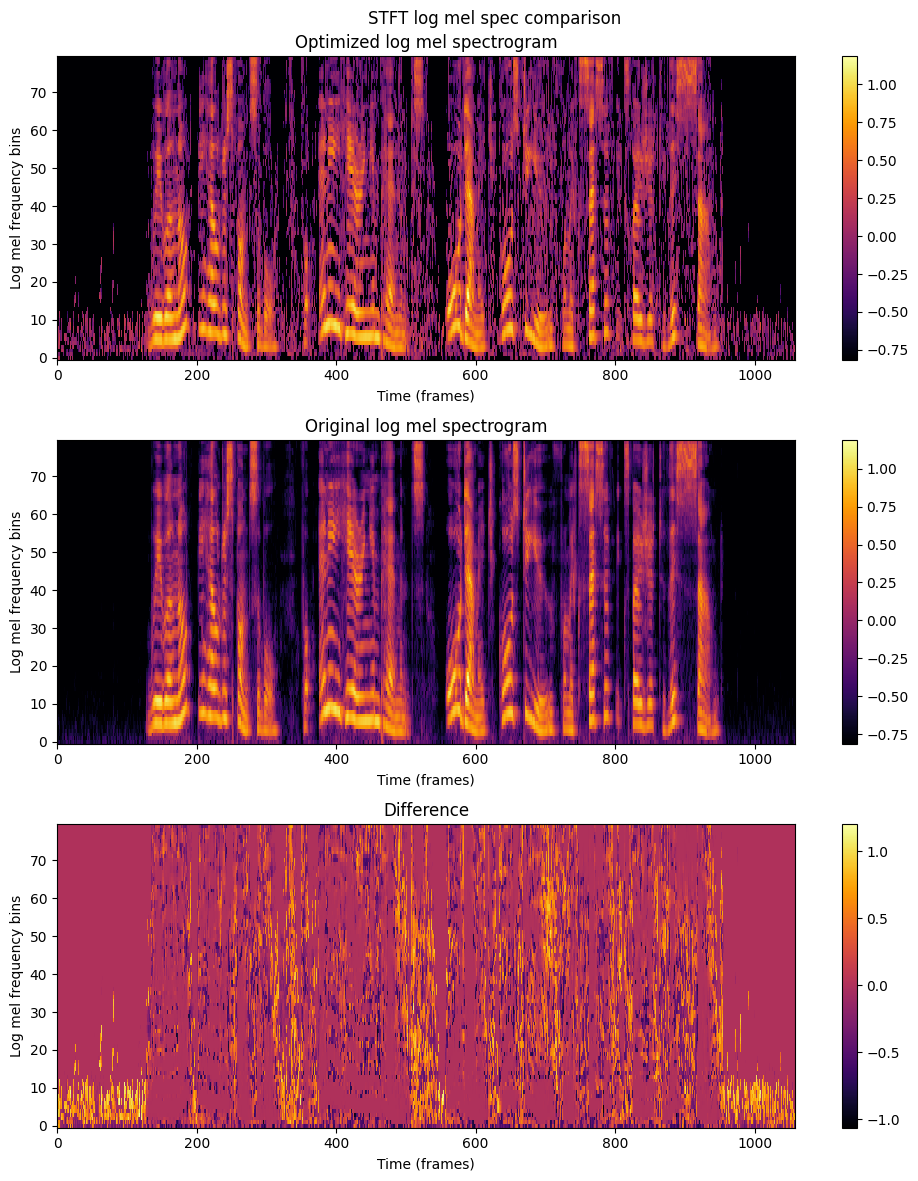

In [7]:
import copy
from tqdm import tqdm

import mlx_whisper.whisper
from mlx_whisper.audio import N_FRAMES, N_SAMPLES, SAMPLE_RATE
import mlx.core as mx

from mlx_audio_opt.stt.transcription import WhisperTranscription
from mlx_audio_opt.audio.spectrogram import Spectrogram


def get_nll(
    model: mlx_whisper.whisper.Whisper,
    magnitudes: mx.array,
    tokens: mx.array,
) -> mx.array:
    log_probs = whisper.get_log_probabilities(
        model=model,
        magnitudes=magnitudes,
        tokens=tokens,
    )
    # mask non-text tokens: Sot, language, task, timestamps, and EOT
    log_probs[:4] = mx.stop_gradient(log_probs[:4])
    log_probs[-2:] = mx.stop_gradient(log_probs[-2:])

    return -mx.sum(log_probs)


def show_audio_from_spectrogram(
    spectrogram: Spectrogram,
    title: str,
):
    """Reconstruct audio and show it."""
    audio_reconstructed = reconstruct_audio_from_spectrogram(
        spectrogram=spectrogram,
    )
    display_audio_player(audio_reconstructed, title=title)


def optimize_audio(
    wav_file: Path,
    model_id: str,
    dtype: str,
    transcription: WhisperTranscription,
    num_iterations: int = 100,
    learning_rate: float = 0.01,
):
    """Optimize audio to influence Whisper output."""

    print("Optimizing audio:")
    print(f"  wav_file: {wav_file}")
    print(f"  model_id: {model_id}")
    print(f"  dtype: {dtype}")

    model = ModelHolder.get_model(model_path=model_id, dtype=dtype)
    tokenizer = get_tokenizer(
        model.is_multilingual,
        num_languages=model.num_languages,
        language="en",
        task="transcribe",
    )

    # Get audio from the wav file, tokens from transcription
    audio_series = load_audio(Path(wav_file).as_posix())
    tokens = list(tokenizer.sot_sequence) + transcription.get_tokens() + [tokenizer.eot]
    token_array = mx.broadcast_to(mx.array(tokens), (1, len(tokens)))

    # Whisper expects a silence-padded waveform, so note magnitudes is effectively padded!
    spectrogram = get_spectrogram(audio_series, pad_audio=N_SAMPLES)
    magnitudes_array = spectrogram.whisper_tensor
    original_nll = get_nll(model, magnitudes_array, token_array)

    # note that audio was padded - we need this number to trim spectrograms later
    n_content_frames = spectrogram.num_frames - N_FRAMES
    original_spectrogram = spectrogram.trim(n_frames=n_content_frames)

    show_audio_from_spectrogram(
        spectrogram.trim(n_frames=n_content_frames),
        title=f"Original, nll={original_nll:.4f}",
    )

    # optimize the audio
    progressbar = tqdm(range(num_iterations), desc="Optimizing audio", unit="iteration")
    for iteration in progressbar:
        loss_fn = mx.value_and_grad(get_nll, argnums=1)
        loss, grad = loss_fn(model, magnitudes_array, token_array)

        progressbar.set_description(f"Optimizing audio, nll={loss:.5f}")
        magnitudes_array = magnitudes_array + learning_rate * grad
    progressbar.close()

    # update the spectrogram
    new_nll = get_nll(model, magnitudes_array, token_array)

    new_spectrogram = Spectrogram.from_whisper(magnitudes_array)
    new_spectrogram.phase = original_spectrogram.phase
    new_spectrogram = new_spectrogram.trim(n_frames=n_content_frames)

    fig = show_audio_from_spectrogram(
        new_spectrogram,
        title=f"Optimized, nll={new_nll:.4f}",
    )

    fig = compare_spectrograms(
        magnitudes1=magnitudes_to_log_mel_spectrogram(
            new_spectrogram.whisper_tensor,
            n_mels=model.dims.n_mels,
        ).T,
        magnitudes2=magnitudes_to_log_mel_spectrogram(
            original_spectrogram.whisper_tensor,
            n_mels=model.dims.n_mels,
        ).T,
        title1="Optimized log mel spectrogram",
        title2="Original log mel spectrogram",
        suptitle="STFT log mel spec comparison",
        ylabel="Log mel frequency bins",
    )
    fig.show()
    return new_spectrogram


optimized_spectrogram: Spectrogram = optimize_audio(
    wav_file=Settings.wav_file,
    model_id=Settings.model_id,
    dtype=Settings.dtype,
    transcription=transcription,
    num_iterations=200,
)

And then for the real test: does this impact the transcription as well?

Let's first write the audio to a .wav file to avoid any floating point related cheating. 

Wrote optimized audio to /Users/auke/code/deepgram/analysis/notebook/optimized_33711__acclivity__excessiveexposure.wav


/var/folders/fg/2msvg0hj1gs09dhp19vt6c900000gn/T/ipykernel_23682/1827963846.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


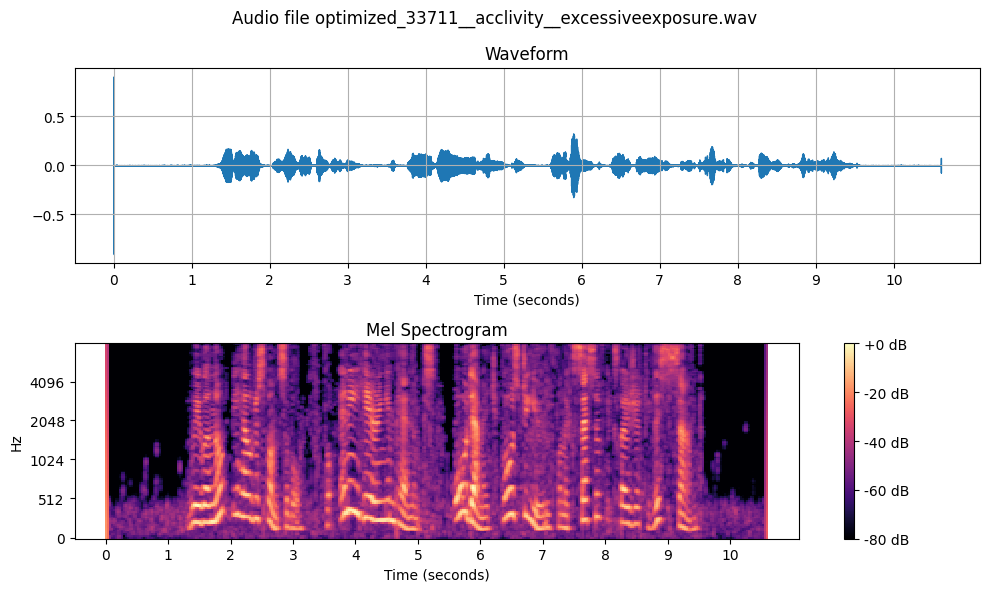

In [8]:
import soundfile
from mlx_audio_opt.audio.istft import reconstruct_audio_from_spectrogram
from mlx_audio_opt.visualization.plot_audio import visualize_audio

# write audio to file to avoid any floating point cheating during transcription
audio_reconstructed = reconstruct_audio_from_spectrogram(optimized_spectrogram)

optimized_file = (
    REPO_ROOT / "analysis/notebook/" / f"optimized_{Settings.wav_file.stem}.wav"
)
optimized_file.parent.mkdir(parents=True, exist_ok=True)
soundfile.write(
    optimized_file,
    audio_reconstructed,
    samplerate=SAMPLE_RATE,
)
print(f"Wrote optimized audio to {optimized_file}")
fig = visualize_audio(optimized_file, sampling_rate=SAMPLE_RATE)
fig.show()

/Users/auke/code/deepgram/mlx_audio_opt/visualization/plot_transcription.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


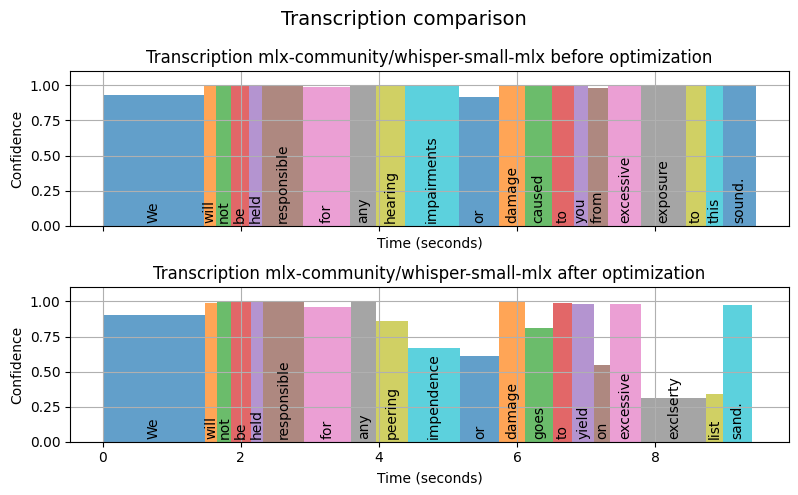

In [9]:
from mlx_audio_opt.visualization.plot_transcription import plot_transcriptions

transcription_before = whisper.transcribe_audio(
    audio=Settings.wav_file,
    model_id=Settings.model_id,
    fp16=(Settings.dtype == "fp16"),
)
transcription_after = whisper.transcribe_audio(
    audio=optimized_file,
    model_id=Settings.model_id,
    fp16=(Settings.dtype == "fp16"),
)

plot_transcriptions(
    suptitle="Transcription comparison",
    transcriptions={
        f"{Settings.model_id} before optimization": transcription_before,
        f"{Settings.model_id} after optimization": transcription_after,
    },
)
plt.show()

Sure looks like we can change the output! 

Some observations:
- it may be easier to change later words probabilities for this sentence. It's possible that small changes in audio earlier in the segment can inadvertently impact later probabilities, but not vice versa.
- some wrong words appear with very high confidence. I'd argue we're succesful: we can clearly fool the Whisper model into producing different transcriptions.

Now one might ask: does this fool other models as well? That seems unlikely, given that the perturbation is whisper specific..

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 104857.60it/s]
/Users/auke/code/deepgram/mlx_audio_opt/visualization/plot_transcription.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


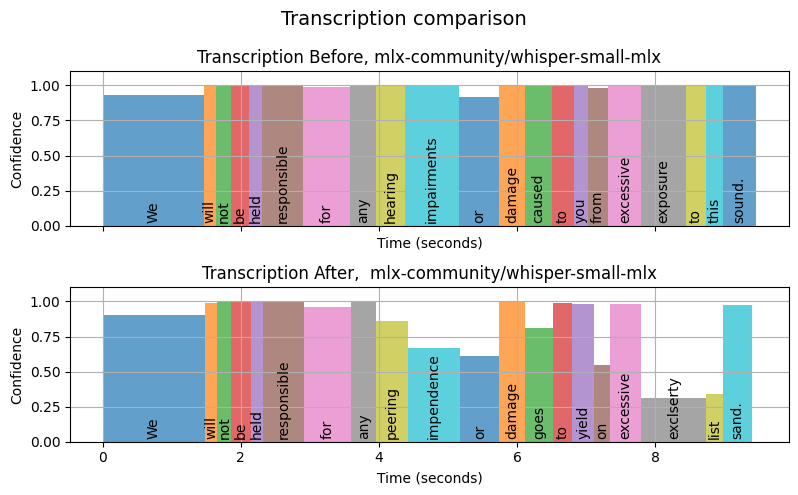

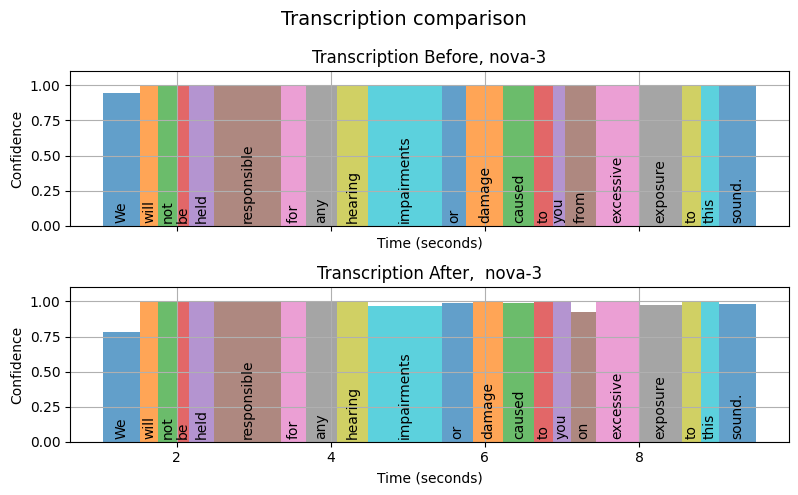

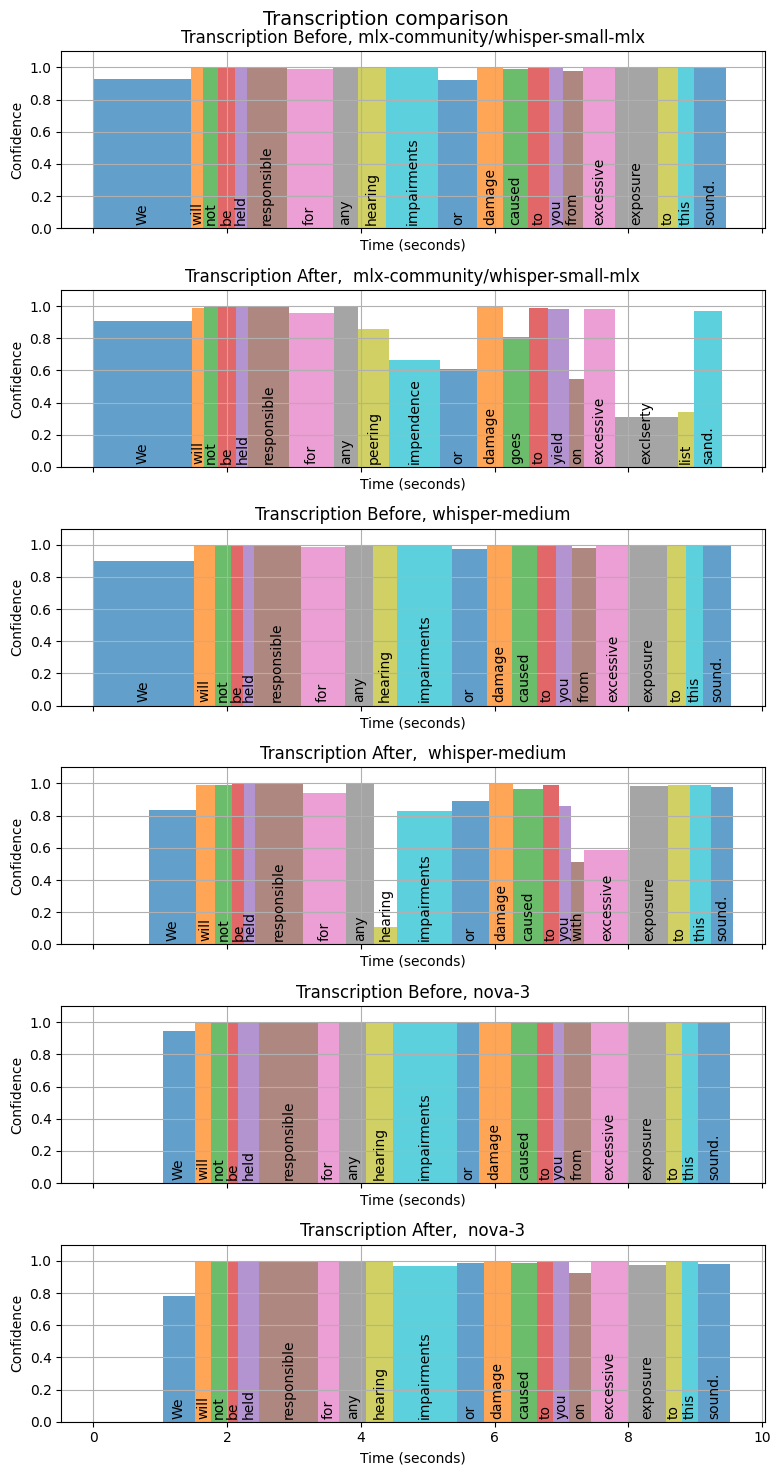

In [10]:
from mlx_audio_opt.stt import whisper, deepgram
from mlx_audio_opt.visualization.plot_transcription import plot_transcriptions

whisper_medium_transcription_before = whisper.transcribe_audio(
    audio=Settings.wav_file,
    model_id="mlx-community/whisper-medium-mlx-fp32",
    fp16=False,
)
whisper_medium_transcription_after = whisper.transcribe_audio(
    audio=optimized_file,
    model_id="mlx-community/whisper-medium-mlx-fp32",
    fp16=False,
)
nova_transcription_before = deepgram.transcribe_audio(
    audio=Settings.wav_file,
    model_id="nova-3",
)
nova_transcription_after = deepgram.transcribe_audio(
    audio=optimized_file,
    model_id="nova-3",
)
plot_transcriptions(
    suptitle="Transcription comparison",
    transcriptions={
        f"Before, {Settings.model_id}": transcription_before,
        f"After,  {Settings.model_id}": transcription_after,
    },
)
plot_transcriptions(
    suptitle="Transcription comparison",
    transcriptions={
        f"Before, nova-3": nova_transcription_before,
        f"After,  nova-3": nova_transcription_after,
    },
)

plot_transcriptions(
    suptitle="Transcription comparison",
    transcriptions={
        f"Before, {Settings.model_id}": transcription_before,
        f"After,  {Settings.model_id}": transcription_after,
        f"Before, whisper-medium": whisper_medium_transcription_before,
        f"After,  whisper-medium": whisper_medium_transcription_after,
        f"Before, nova-3": nova_transcription_before,
        f"After,  nova-3": nova_transcription_after,
    },
)
plt.show()

Perhaps unsurprisingly, adversarial perturbations only affect the model for which they were optimized.

Possible next steps include:

1. Finding universal perturbations that fool multiple (open-weight) models, for example by optimizing for multiple models simultaneously.
2. Targeting specific tokens: see if we can get Whisper to output a specific sentence.
3. Collecting a larger set of audio samples, perturbing them, then training the model to become more robust.

I believe adversarial robustness is most relevant for open-weight models. 
For me, the goal of this investigation was to learn how `mlx-whisper` and the Whisper models work, and to see if they can be fooled.
The answer to that question is yes, absolutely.

Black or gray box adversarial attacks are likely possible as well, but they are a lot more expensive.
Assuming that many real-world agents will be controlled by voice, we may see a renewed interest in [phreaking](https://en.wikipedia.org/wiki/Phreaking), but with slightly more advanced tools.
In that case, adversarial robustness will also become more important.
